# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Preample

### Import Statements

In [87]:
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
%matplotlib inline

### Dataset

In [2]:
car_images = glob.glob('../vehicles/**/*.png')
noncar_images = glob.glob('../non-vehicles/**/*.png')
print("Car Images: ", len(car_images))
print("Non-Car Images: ", len(noncar_images))
img = cv2.imread(car_images[0])
print("Image size: ", img.shape)

Car Images:  8792
Non-Car Images:  8968
Image size:  (64, 64, 3)


## Feature Extraction

### Histogram of Oriented Gradients (HOG) feature extraction

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Text(0.5,1,'HOG')

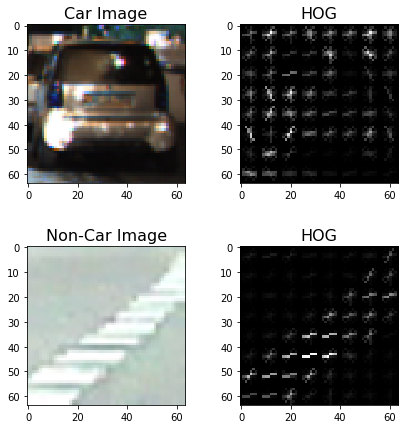

In [4]:
car_img = cv2.imread(car_images[0])
f, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
ncar_img = cv2.imread(noncar_images[0])
f, ncar_dst = get_hog_features(ncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('HOG', fontsize=16)
ax3.imshow(ncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(ncar_dst, cmap='gray')
ax4.set_title('HOG', fontsize=16)

### Spatial Binning of Color feature extraction

In [5]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

Text(0.5,1,'Bin Spatial')

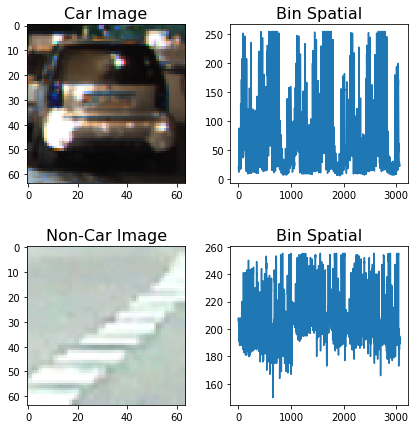

In [6]:
car_img = cv2.imread(car_images[0])
car_dst = bin_spatial(car_img)
ncar_img = cv2.imread(noncar_images[0])
ncar_dst = bin_spatial(ncar_img)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.plot(car_dst)
ax2.set_title('Bin Spatial', fontsize=16)
ax3.imshow(ncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.plot(ncar_dst)
ax4.set_title('Bin Spatial', fontsize=16)

### Color Histogram feature extraction

In [63]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

Text(0.5,1,'Color Histogram')

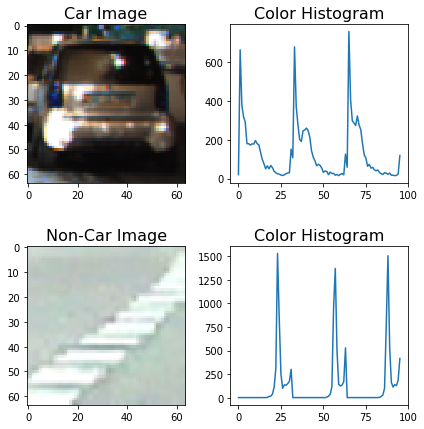

In [64]:
car_img = cv2.imread(car_images[0])
car_dst = color_hist(car_img)
ncar_img = cv2.imread(noncar_images[0])
ncar_dst = color_hist(ncar_img)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.plot(car_dst)
ax2.set_title('Color Histogram', fontsize=16)
ax3.imshow(ncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.plot(ncar_dst)
ax4.set_title('Color Histogram', fontsize=16)

### Feature Extraction parameter tuning

In [ ]:
def color_conversion(image, cspace):
    # apply color conversion if other than 'BGR'
    if cspace != 'BGR':
        if cspace == 'RGB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(image)
    return feature_image

In [ ]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)    
        feature_image = color_conversion(image, cspace)
        # Call get_hog_features() with vis=False, feature_vec=True
        channels = np.arange(feature_image.shape[2]) if hog_channel == 'ALL' else [hog_channel]
        local_features = []
        for channel in channels:
            local_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell,
                                  cell_per_block, vis=False, feature_vec=True))
            # print('hog: ', local_features[-1].shape)
        local_features.append(bin_spatial(feature_image))
        # print('spatial: ', local_features[-1].shape)
        local_features.append(color_hist(feature_image))
        # print('color: ', local_features[-1].shape)
        features.append(np.hstack(local_features))
        # print('all:', features[-1].shape)
    # Return list of feature vectors
    # print('all:', features[-1].shape)
    return features

In [ ]:
# Feature extraction parameters
def process_data(car_images, ncar_images, cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    t = time.time()
    car_features = extract_features(car_images, cspace=cspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    # print(car_features[0].shape)
    notcar_features = extract_features(ncar_images, cspace=cspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    # print(notcar_features[0].shape)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)  
    # Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    print('Feature vector length:', len(X_train[0]))
    return X_train, X_test, y_train, y_test, X_scaler

In [ ]:
def train_clf_gs(X_train, y_train, kernel=('linear', 'rbf'), C=[1, 10, 50], gamma=np.arange(0, 1.1, 0.1)):
    parameters = {'kernel':kernel, 'C':C, 'gamma':gamma}
    svr = SVC()
    clf = GridSearchCV(svr, parameters)
    # Check the training time for the SVC
    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    print("Best params:", clf.best_params_)
    return clf

def train_clf(X_train, y_train, kernel='rbf', C=50, gamma='auto'):
    clf = SVC(kernel=kernel, C=C, gamma=gamma)
    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    return clf

In [ ]:
def test_clf(clf, X_test, y_test):
    return round(clf.score(X_test, y_test), 4)

In [ ]:
def parameter_tuning(car_images, ncar_images):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    for cspace in ["RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"]:
        for channel in [0, 1, 2, "ALL"]:
            print("Params:", " cspace:", cspace, " channel:", channel, ' orient:', orient,
                  ' pix_per_cell:', pix_per_cell, ' cell_per_block:', cell_per_block)
            X_train, X_test, y_train, y_test, _ = process_data(car_images, ncar_images, cspace, orient=orient, 
                                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                            hog_channel=channel)
            clf = train_clf(X_train, y_train)
            acc = test_clf(clf, X_test, y_test)
            print("Accuracy:", acc)

In [116]:
parameter_tuning(car_images, noncar_images)

Params:  cspace: RGB  channel: 0  orient: 9  pix_per_cell: 8  cell_per_block: 2
32.25 Seconds to extract HOG features...
Feature vector length: 1764
220.96 Seconds to train SVC...
Accuracy:  0.8663
Params:  cspace: RGB  channel: 1  orient: 9  pix_per_cell: 8  cell_per_block: 2
32.2 Seconds to extract HOG features...
Feature vector length: 1764
197.77 Seconds to train SVC...
Accuracy:  0.8846
Params:  cspace: RGB  channel: 2  orient: 9  pix_per_cell: 8  cell_per_block: 2
32.21 Seconds to extract HOG features...
Feature vector length: 1764
196.72 Seconds to train SVC...
Accuracy:  0.882
Params:  cspace: RGB  channel: ALL  orient: 9  pix_per_cell: 8  cell_per_block: 2
89.36 Seconds to extract HOG features...
Feature vector length: 5292
548.31 Seconds to train SVC...
Accuracy:  0.8798
Params:  cspace: HSV  channel: 0  orient: 9  pix_per_cell: 8  cell_per_block: 2
32.81 Seconds to extract HOG features...
Feature vector length: 1764
165.27 Seconds to train SVC...
Accuracy:  0.9054
Params:  c

## Classifier

### Train a classifier
The parameter exploration above showed best accuracy with the following combination of parameters
* colorspace: **YCrCb**
* channels: **ALL**
* orientations: **9**
* pixels per cell: **8**
* cells per block: **2**

In [161]:
colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' 

In [177]:
X_train, X_test, y_train, y_test, X_scaler = process_data(car_images, noncar_images, colorspace, orient, 
                                                pix_per_cell, cell_per_block, hog_channel)
print('Train set size:', len(X_train))
print('Test set size:', len(X_test))
clf = train_clf(X_train, y_train)
acc = test_clf(clf, X_test, y_test)
print("Accuracy:", acc)

all: (8460,)
(8460,)
all: (8460,)
(8460,)
98.02 Seconds to extract HOG features...
Feature vector length: 8460
Train set size: 14208
Test set size: 3552
367.52 Seconds to train SVC...
Accuracy:  0.9947


### Find Cars

In [200]:
def find_cars(img, ystart, ystop, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block,  hog_channel=hog_channel, colorspace=colorspace,
              spatial_size=(32,32), hist_bins=32, hist_bins_range=(0,256), return_all=False):
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = color_conversion(img_tosearch, colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            features = []
            features.append(hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
            # print('hog: ', features[-1].shape)
            if hog_channel == 'ALL':
                features.append(hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
                # print('hog: ', features[-1].shape)
                features.append(hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
                # print('hog: ', features[-1].shape)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            features.append(bin_spatial(subimg))
            # print('spatial: ', features[-1].shape)
            features.append(color_hist(subimg))
            # print('color: ', features[-1].shape)
            
            features_stacked = np.hstack(features)
            # Scale features and make a prediction
            test_features = X_scaler.transform([features_stacked])
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1 or return_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return boxes

In [203]:
def draw_boxes(img, boxes, color=(0,0,255)):
    if color == '*':
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    for box in boxes:
        cv2.rectangle(img, box[0], box[1], color, 6)
    return img

8.42 Seconds to find cars...
0.0 Seconds to draw boxes...
13  boxes found in image


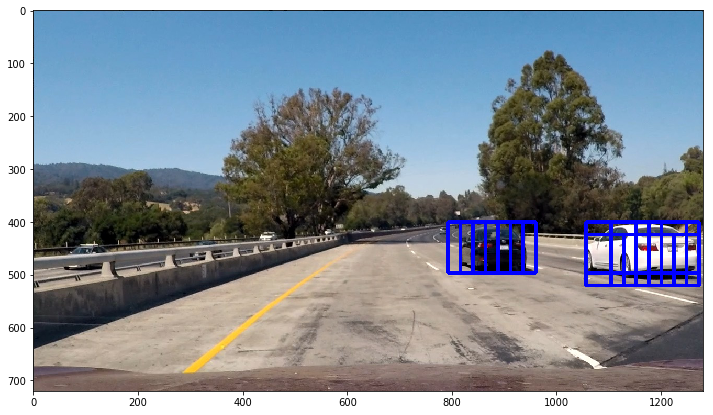

In [199]:
test_img = cv2.imread('./test_images/test1.jpg')
rgb_img = color_conversion(test_img, 'RGB')
ystart = 400
ystop = 656
scale = 1.5

t = time.time()
boxes = find_cars(test_img, ystart, ystop, scale, clf, X_scaler)
print(round(time.time() - t, 2), 'Seconds to find cars...')
t = time.time()
draw_img = draw_boxes(rgb_img, boxes)
print(round(time.time() - t, 2), 'Seconds to draw boxes...')

print(len(boxes), 'boxes found in image')
plt.figure(figsize = (12,7))
plt.imshow(draw_img, aspect='auto')

## Search & Bound

### Experiment with different search areas and sizes

#### Scale 1.0

1.95 Seconds to find cars...
1.9 Seconds to find cars...
154  boxes found in image


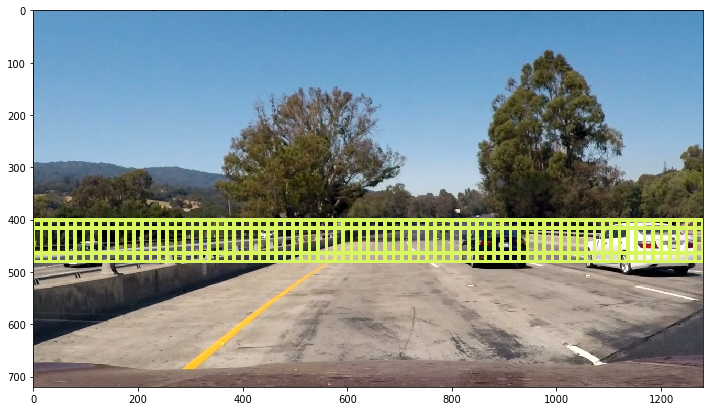

In [211]:
rgb_img = color_conversion(test_img, 'RGB')
scale = 1.0
boxes = []

t = time.time()
boxes.extend(find_cars(test_img, 400, 464, scale, clf, X_scaler, return_all=True))
print(round(time.time() - t, 2), 'Seconds to find cars...')
t = time.time()
boxes.extend(find_cars(test_img, 416, 480, scale, clf, X_scaler, return_all=True))
print(round(time.time() - t, 2), 'Seconds to find cars...')

draw_img = draw_boxes(rgb_img, boxes, color='*')

plt.figure(figsize=(12,7))
plt.imshow(draw_img)
print(len(boxes), 'boxes found in image')

#### scale 1.5

1.24 Seconds to find cars...
1.28 Seconds to find cars...
100  boxes found in image


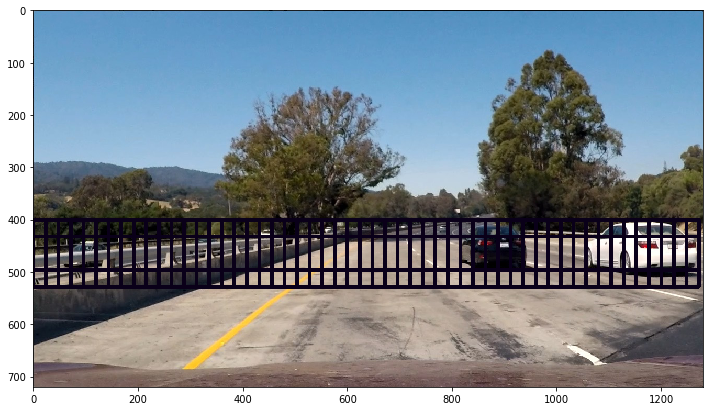

In [212]:
rgb_img = color_conversion(test_img, 'RGB')
scale = 1.5
boxes = []

t = time.time()
boxes.extend(find_cars(test_img, 400, 496, scale, clf, X_scaler, return_all=True))
print(round(time.time() - t, 2), 'Seconds to find cars...')
t = time.time()
boxes.extend(find_cars(test_img, 432, 528, scale, clf, X_scaler, return_all=True))
print(round(time.time() - t, 2), 'Seconds to find cars...')

draw_img = draw_boxes(rgb_img, boxes, color='*')

plt.figure(figsize=(12,7))
plt.imshow(draw_img)
print(len(boxes), 'boxes found in image')

#### scale 2.0

0.95 Seconds to find cars...
0.93 Seconds to find cars...
74  boxes found in image


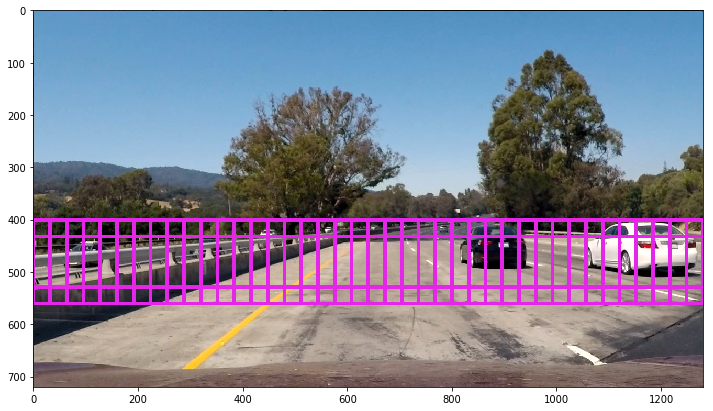

In [213]:
rgb_img = color_conversion(test_img, 'RGB')
scale = 2.0
boxes = []

t = time.time()
boxes.extend(find_cars(test_img, 400, 528, scale, clf, X_scaler, return_all=True))
print(round(time.time() - t, 2), 'Seconds to find cars...')
t = time.time()
boxes.extend(find_cars(test_img, 432, 560, scale, clf, X_scaler, return_all=True))
print(round(time.time() - t, 2), 'Seconds to find cars...')

draw_img = draw_boxes(rgb_img, boxes, color='*')

plt.figure(figsize=(12,7))
plt.imshow(draw_img)
print(len(boxes), 'boxes found in image')

#### scale 3.0

0.61 Seconds to find cars...
0.58 Seconds to find cars...
46  boxes found in image


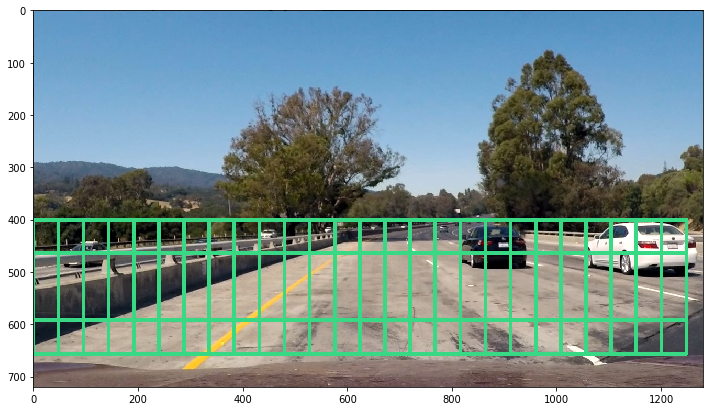

In [214]:
rgb_img = color_conversion(test_img, 'RGB')
scale = 3.0
boxes = []

t = time.time()
boxes.extend(find_cars(test_img, 400, 596, scale, clf, X_scaler, return_all=True))
print(round(time.time() - t, 2), 'Seconds to find cars...')
t = time.time()
boxes.extend(find_cars(test_img, 464, 660, scale, clf, X_scaler, return_all=True))
print(round(time.time() - t, 2), 'Seconds to find cars...')

draw_img = draw_boxes(rgb_img, boxes, color='*')

plt.figure(figsize=(12,7))
plt.imshow(draw_img)
print(len(boxes), 'boxes found in image')

#### Scale combination

9.3 Seconds to find cars...
37  boxes found in image


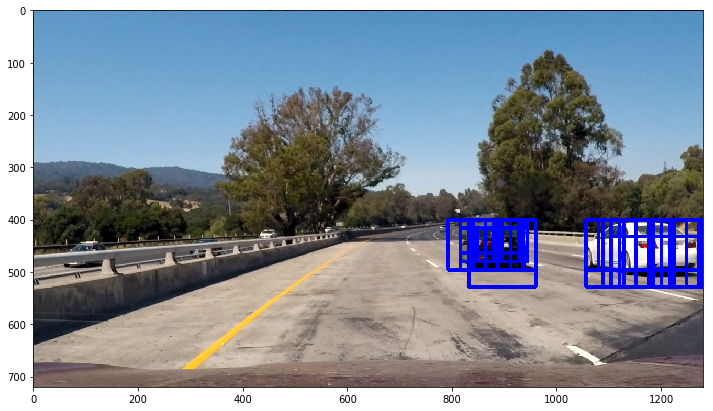

In [221]:
rgb_img = color_conversion(test_img, 'RGB')

t = time.time()
scale = 3.0
boxes.extend(find_cars(test_img, 400, 596, scale, clf, X_scaler))
boxes.extend(find_cars(test_img, 464, 660, scale, clf, X_scaler))
scale = 2.0
boxes.extend(find_cars(test_img, 400, 528, scale, clf, X_scaler))
boxes.extend(find_cars(test_img, 432, 560, scale, clf, X_scaler))
scale = 1.5
boxes.extend(find_cars(test_img, 400, 496, scale, clf, X_scaler))
boxes.extend(find_cars(test_img, 432, 528, scale, clf, X_scaler))
scale = 1.0
boxes.extend(find_cars(test_img, 400, 464, scale, clf, X_scaler))
boxes.extend(find_cars(test_img, 416, 480, scale, clf, X_scaler))
print(round(time.time() - t, 2), 'Seconds to find cars...')

rgb_img = draw_boxes(rgb_img, boxes)

plt.figure(figsize=(12,7))
plt.imshow(rgb_img)
print(len(boxes), 'boxes found in image')

### Heatmap

In [220]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

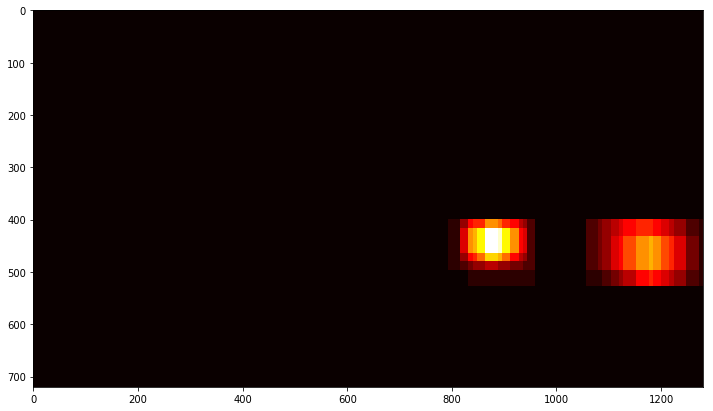

In [223]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, boxes)
plt.figure(figsize=(12,7))
plt.imshow(heatmap_img, cmap='hot')

In [224]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

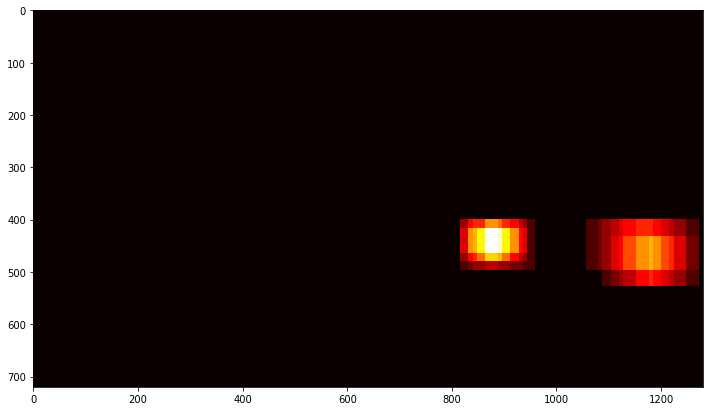

In [225]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(12,7))
plt.imshow(heatmap_img, cmap='hot')

### Label heatmap

2  cars found


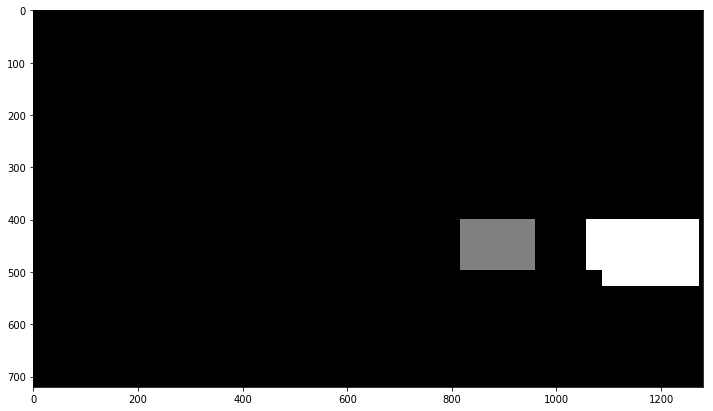

In [226]:
labels = label(heatmap_img)
plt.figure(figsize=(12,7))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw bounding boxes

In [232]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        boxes.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
        # Draw the box on the image
        cv2.rectangle(img, boxes[-1][0], boxes[-1][1], (0,0,255), 6)
    # Return the image
    return img, boxes

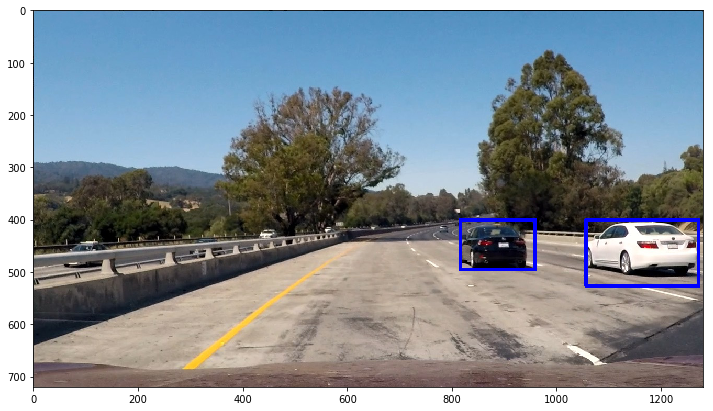

In [233]:
rgb_img = color_conversion(test_img, 'RGB')
# Draw bounding boxes on a copy of the image
draw_img, boxes = draw_labeled_bboxes(rgb_img, labels)
# Display the image
plt.figure(figsize=(12,7))
plt.imshow(draw_img)

## Video Pipeline

In [250]:
def pipeline(img):
    colorspace = 'YCrCb'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' 
    
    boxes = []
    
    scale = 3.0
    boxes.extend(find_cars(img, 400, 596, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block, hog_channel=hog_channel, colorspace=colorspace))
    boxes.extend(find_cars(img, 464, 660, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block,  hog_channel=hog_channel, colorspace=colorspace))
    scale = 2.0
    boxes.extend(find_cars(img, 400, 528, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block, hog_channel=hog_channel, colorspace=colorspace))
    boxes.extend(find_cars(img, 432, 560, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block,  hog_channel=hog_channel, colorspace=colorspace))
    scale = 1.5
    boxes.extend(find_cars(img, 400, 496, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block, hog_channel=hog_channel, colorspace=colorspace))
    boxes.extend(find_cars(img, 432, 528, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block,  hog_channel=hog_channel, colorspace=colorspace))
    scale = 1.0
    boxes.extend(find_cars(img, 400, 464, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block, hog_channel=hog_channel, colorspace=colorspace))
    boxes.extend(find_cars(img, 416, 480, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block, hog_channel=hog_channel, colorspace=colorspace))
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    rgb_img = color_conversion(img, 'RGB')
    draw_img, rects = draw_labeled_bboxes(rgb_img, labels)
    return draw_img

def video_preproc(img):
    img2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return pipeline(img2)

### Execute on test images

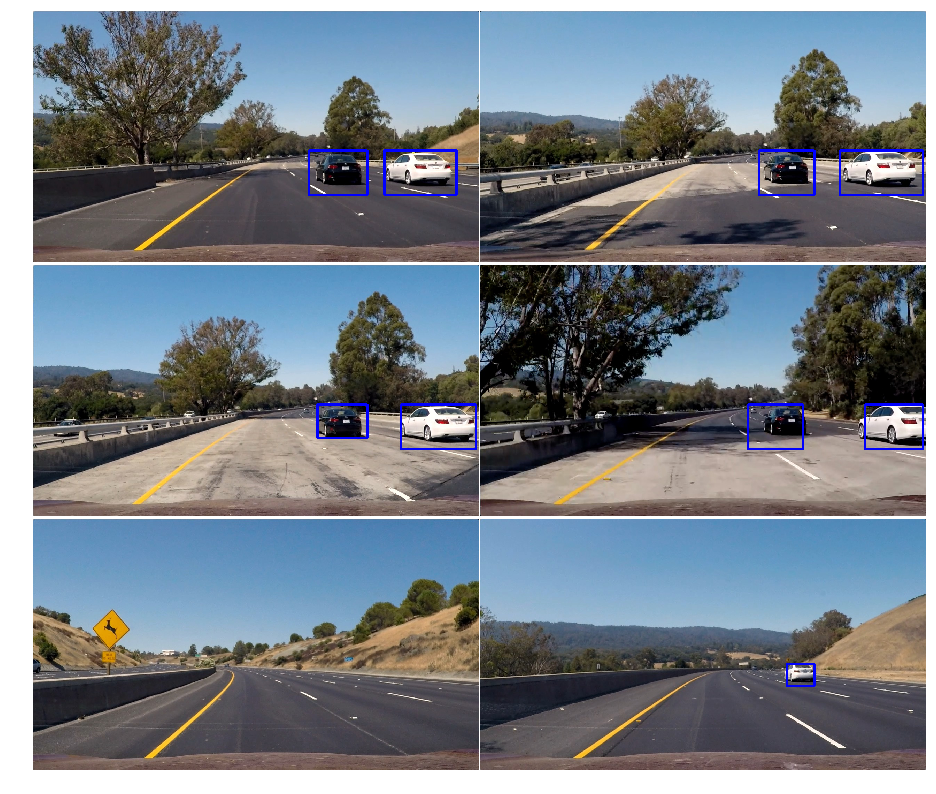

In [251]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(pipeline(cv2.imread(im)))
    axs[i].axis('off')

###  Execute on test video

In [252]:
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(video_preproc)
%time clip_test_out.write_videofile('test_video_out.mp4', audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [06:01<00:09,  9.51s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 11min 14s, sys: 7.21 s, total: 11min 21s
Wall time: 6min 2s


In [254]:
HTML("""
<video width="640" height="480" controls>
  <source src="{0}">
</video>
""".format('test_video_out.mp4'))

### Implement a detection cache

In [261]:
class DetectionCache():
    
    def __init__(self, size = 15):
        # history of rectangles previous n frames
        self.boxes = []
        self.size = size
        
    def add_boxes(self, boxes):
        if len(boxes) == 0:
            return
        self.boxes.append(boxes)
        if len(self.boxes) > self.size:
            # throw out oldest rectangle set(s)
            self.boxes = self.boxes[len(self.boxes)-self.size:]

###  Pipeline with cache

In [260]:
def pipelineCache(img):
    colorspace = 'YCrCb'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' 
    
    boxes = []
    
    scale = 3.0
    boxes.extend(find_cars(img, 400, 596, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block, hog_channel=hog_channel, colorspace=colorspace))
    boxes.extend(find_cars(img, 464, 660, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block,  hog_channel=hog_channel, colorspace=colorspace))
    scale = 2.0
    boxes.extend(find_cars(img, 400, 528, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block, hog_channel=hog_channel, colorspace=colorspace))
    boxes.extend(find_cars(img, 432, 560, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block,  hog_channel=hog_channel, colorspace=colorspace))
    scale = 1.5
    boxes.extend(find_cars(img, 400, 496, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block, hog_channel=hog_channel, colorspace=colorspace))
    boxes.extend(find_cars(img, 432, 528, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block,  hog_channel=hog_channel, colorspace=colorspace))
    scale = 1.0
    boxes.extend(find_cars(img, 400, 464, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block, hog_channel=hog_channel, colorspace=colorspace))
    boxes.extend(find_cars(img, 416, 480, scale, clf, X_scaler, orient=orient, pix_per_cell=pix_per_cell,
              cell_per_block=cell_per_block, hog_channel=hog_channel, colorspace=colorspace))
    
    cache.add_boxes(boxes)
        
    heatmap_img = np.zeros_like(img[:,:,0])
    for bx in cache.boxes:
        heatmap_img = add_heat(heatmap_img, bx)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(cache.boxes)//2)
    
    labels = label(heatmap_img)
    
    rgb_img = color_conversion(img, 'RGB')
    draw_img, rects = draw_labeled_bboxes(rgb_img, labels)
    
    return draw_img

def video_preproc_cache(img):
    img2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return pipelineCache(img2)

In [ ]:
cache = DetectionCache()

clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(video_preproc_cache)
%time clip_test_out2.write_videofile('test_video_out_cache.mp4', audio=False)

[MoviePy] >>>> Building video test_video_out_cache.mp4
[MoviePy] Writing video test_video_out_cache.mp4


 64%|██████▍   | 25/39 [03:58<02:13,  9.55s/it]